In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dltime.base.layers import ConvBlock
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from dltime.models.FCN import FCN
from dltime.models.InceptionTime import InceptionTime
from tqdm import tqdm
%matplotlib inline

In [3]:
from dltime.data.ts_datasets import Soil_Dataset
from utils import load_pkl
from data_process import handle_dataset_3dims
import torch.nn as nn
from torch.utils.data import DataLoader
from dltime.models.InceptionTime import InceptionTime

- 频谱
- 能量谱
- 希尔伯特黄变换

In [4]:
def infer_fn(valid_loader, model, device):
    model.eval()
    preds = []
    for step, item in enumerate(valid_loader):
        for k, v in item.items():
            item[k] = v.to(device)

        labels = item['label']
        with torch.no_grad():
            y_preds = model(item['input'])

        preds.append(np.argmax(y_preds.detach().cpu().numpy(), 1))
    
    predictions = np.concatenate(preds)
    return predictions

In [5]:
model = InceptionTime(c_in=5, c_out=3).to('cuda')
model.load_state_dict(torch.load('.\outputs\zwy_2022-08-03 01.26.pth'))

<All keys matched successfully>

In [6]:
def get_sample(data_name):
    train_data = load_pkl(f'./pickle_data/{data_name}_train_64.pkl')
    test_data = load_pkl(f'./pickle_data/{data_name}_test_64.pkl')
    total_data = train_data + test_data
    total_x, total_label = handle_dataset_3dims(total_data, mode="all")
    total_x = np.swapaxes(total_x, 2, 1)
    total_dataset = Soil_Dataset(total_x, total_label, normalize=None, channel_first=True)
    total_dataloader = DataLoader(total_dataset, batch_size=16, shuffle=False, drop_last=False)
    preds = infer_fn(total_dataloader, model, "cuda")
    return total_data, preds


sky2_samples, sky2_preds = get_sample("sky2")
zwy_samples, zwy_preds = get_sample("zwy")

In [7]:
zwy_true_idx = [idx for idx, sample in enumerate(zwy_samples) if sample['label'] == 0 and zwy_preds[idx] == 0 and '0.0' in sample['file_name']]
zwy_wrong_idx = [idx for idx, sample in enumerate(zwy_samples) if sample['label'] == 0 and zwy_preds[idx] != 0 and '0.0' in sample['file_name']]

sky2_true_idx = [idx for idx, sample in enumerate(sky2_samples) if sample['label'] == 0 and sky2_preds[idx] == 0 and '0.0' in sample['file_name']]
sky2_wrong_idx = [idx for idx, sample in enumerate(sky2_samples) if sample['label'] == 0 and sky2_preds[idx] != 0 and '0.0' in sample['file_name']]

In [8]:
zwy_samples[0]

{'data_x': array([-0.01593399, -0.01592636, -0.01597786, -0.01576233, -0.01588058,
        -0.01596642, -0.01588631, -0.0158844 , -0.01583481, -0.01595497,
        -0.01569176,  0.00092697, -0.0534935 ,  0.00029945, -0.00503922,
        -0.02468681, -0.00935745, -0.01294518, -0.00675964,  0.00806999,
         0.0203743 , -0.05534363, -0.10305405, -0.09128571,  0.10072517,
         0.0312767 , -0.03656387, -0.07186317, -0.0300312 ,  0.01339722,
         0.01138687, -0.02391624, -0.03528023, -0.02140427, -0.00404739,
        -0.01018143, -0.01895523, -0.02089119, -0.01524544, -0.01420021,
        -0.01613808, -0.01625633, -0.01625061, -0.01615906, -0.01576233,
        -0.01623917, -0.01590347, -0.0154438 , -0.01535797, -0.01664352,
        -0.01665497, -0.01544952, -0.01480293, -0.01602745, -0.01668739,
        -0.01603127, -0.01538467, -0.01623535, -0.01645088, -0.01583672,
        -0.01567078, -0.01580048, -0.01603699, -0.01591873]),
 'data_y': array([-0.0512085 , -0.05142403, -0.05131

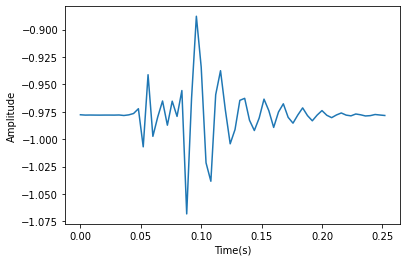

In [9]:
from scipy.fft import fft

sample = zwy_samples[zwy_true_idx[0]]['data_z']
x = sample
fs = 250
T = 1 / fs
L = len(sample)

fft_x = fft(x)
t = [i * T for i in range(L)]
plt.plot(t, x)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.show()

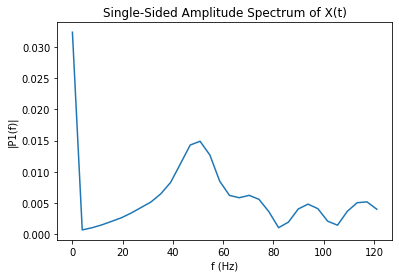

In [35]:
# fft
fft_x = fft(x)
p2 = np.abs(fft_x)   # 双侧频谱
p1 = p2[:int(L/2)]
f = np.arange(int(L/2))*fs/L
plt.plot(f[:],2*p1[:]/L) 
plt.title('Single-Sided Amplitude Spectrum of X(t)')
plt.xlabel('f (Hz)')
plt.ylabel('|P1(f)|')
plt.show()

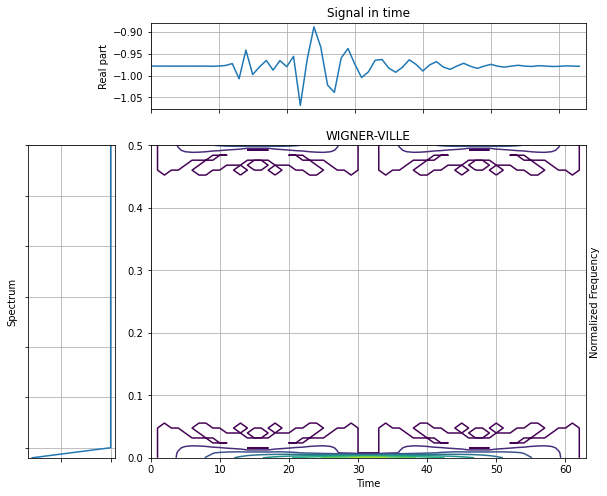

In [34]:
from tftb.generators import anapulse
from tftb.processing import WignerVilleDistribution

x = zwy_samples[zwy_true_idx[0]]['data_x']
y = zwy_samples[zwy_true_idx[0]]['data_y']
z = zwy_samples[zwy_true_idx[0]]['data_z']
wvd = WignerVilleDistribution(z)
wvd.run()
wvd.plot(kind="contour", show_tf=True)


In [11]:
# 希尔伯特黄变换
from pyhht import EMD
from scipy.signal import hilbert
from scipy.fft import fft

In [12]:
# zwy三个场地上都为dig
idx = np.random.choice(zwy_true_idx, size=6, replace=False)
item1 = {'data': zwy_samples[idx[0]]['data_z'], 'label': zwy_samples[idx[0]]['label'], 'pred': zwy_preds[idx[0]]}
item2 = {'data': zwy_samples[idx[1]]['data_z'], 'label': zwy_samples[idx[1]]['label'], 'pred': zwy_preds[idx[1]]}
item3 = {'data': zwy_samples[idx[2]]['data_z'], 'label': zwy_samples[idx[2]]['label'], 'pred': zwy_preds[idx[2]]}
item4 = {'data': zwy_samples[idx[3]]['data_z'], 'label': zwy_samples[idx[3]]['label'], 'pred': zwy_preds[idx[3]]}
item5 = {'data': zwy_samples[idx[4]]['data_z'], 'label': zwy_samples[idx[4]]['label'], 'pred': zwy_preds[idx[4]]}
item6 = {'data': zwy_samples[idx[5]]['data_z'], 'label': zwy_samples[idx[5]]['label'], 'pred': zwy_preds[idx[5]]}
item_list = [item1, item2, item3, item4, item5, item6]

In [13]:
# 画希尔伯特黄变换
def plot_fft(item_list):
    plt.figure(figsize=(20, 10))
    fs = 250
    T = 1 / fs
    L = 64
    t = [i * T for i in range(L)]

    # item_list = [item1, item2, item3, item4]
    item_cnt = len(item_list)
    for idx, item in enumerate(item_list):
        plt.subplot(4, item_cnt, idx+1)
        plt.plot(t, item['data'])
        plt.title(f"label {item['label']} pred {item['pred']}")
        
        # 频谱
        fft_x = fft(item['data'])
        p2 = np.abs(fft_x)   # 双侧频谱
        p1 = p2[: L // 2]
        f = np.arange(L // 2) * fs / L
        plt.subplot(4, item_cnt, item_cnt+idx+1)
        plt.plot(f[1:], p1[1:])
        # plt.title("频谱")

        # 能量谱
        plt.subplot(4, item_cnt, item_cnt*2+idx+1)
        plt.plot(f[1:], p1[1:]**2)
        # plt.title("能量谱")
        
        # 功率谱
        # plt.subplot(5, item_cnt, item_cnt*3+idx+1)
        # plt.plot(f[1:], p1[1:]**2 / L)

        # 倒频谱
        ceps = np.fft.ifft(np.log(p2)).real
        plt.subplot(4, item_cnt, item_cnt*3+idx+1)
        plt.plot(f[1:], ceps[1: L//2])
        
    plt.show()


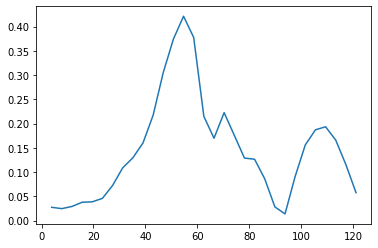

In [14]:
fft_x = fft(sample)
p2 = np.abs(fft_x)   # 双侧频谱
p1 = p2[: L // 2]
f = np.arange(L // 2) * fs / L
plt.plot(f[1:], p1[1:])
plt.show()

In [17]:
noise = np.random.rand(2048)
print("频域能量", sum(abs(fft(noise))**2) / (2048 ** 2))
print("时域能量", sum(noise**2) / 2048)

频域能量 0.33893889660730686
时域能量 0.33893889660730697


In [18]:
# 画希尔伯特黄变换
def plot_hht(item_list):
    plt.figure(figsize=(20, 10))
    n_components = 4

    # item_list = [item1, item2, item3, item4]
    item_cnt = len(item_list)
    for idx, item in enumerate(item_list):
        decomposer = EMD(item['data'])
        imfs = decomposer.decompose()
        plt.subplot(n_components+1, item_cnt, idx+1)
        plt.plot(item['data'])
        plt.title(f"label {item['label']} pred {item['pred']}")
        for i in range(n_components):
            plt.subplot(n_components+1, item_cnt, (i+1)*len(item_list) + idx+1)
            plt.plot(imfs[i])
    plt.show()


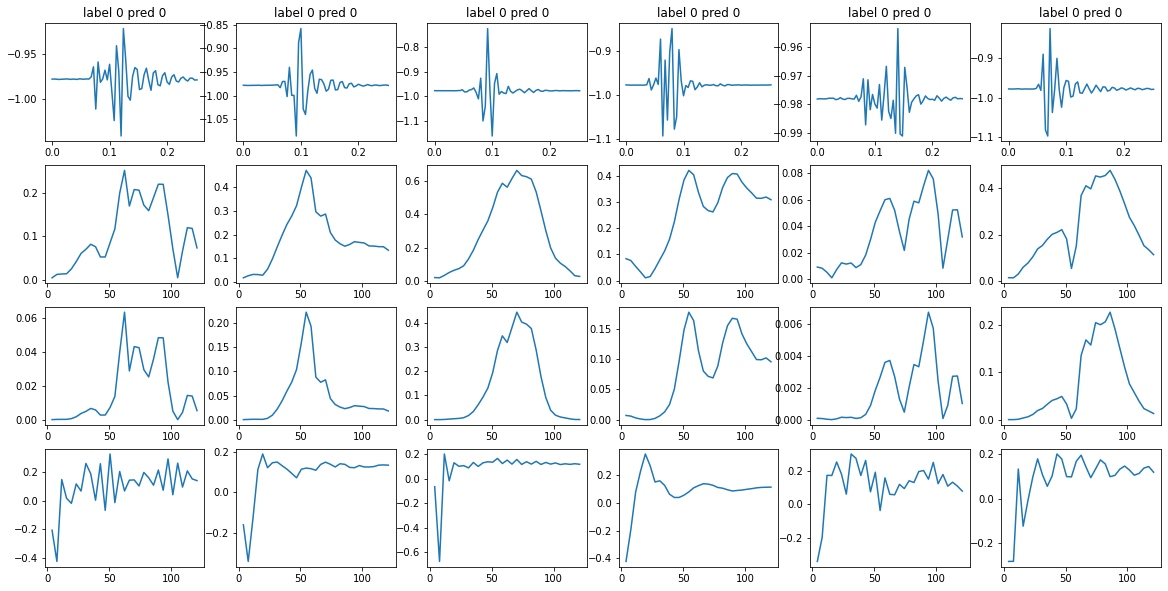

In [19]:
plot_fft(item_list)
# 短时傅里叶变换, 能量谱分析一下, z轴频谱分析作为模型输入, 嵌入式实现能量谱、希尔伯特黄变换

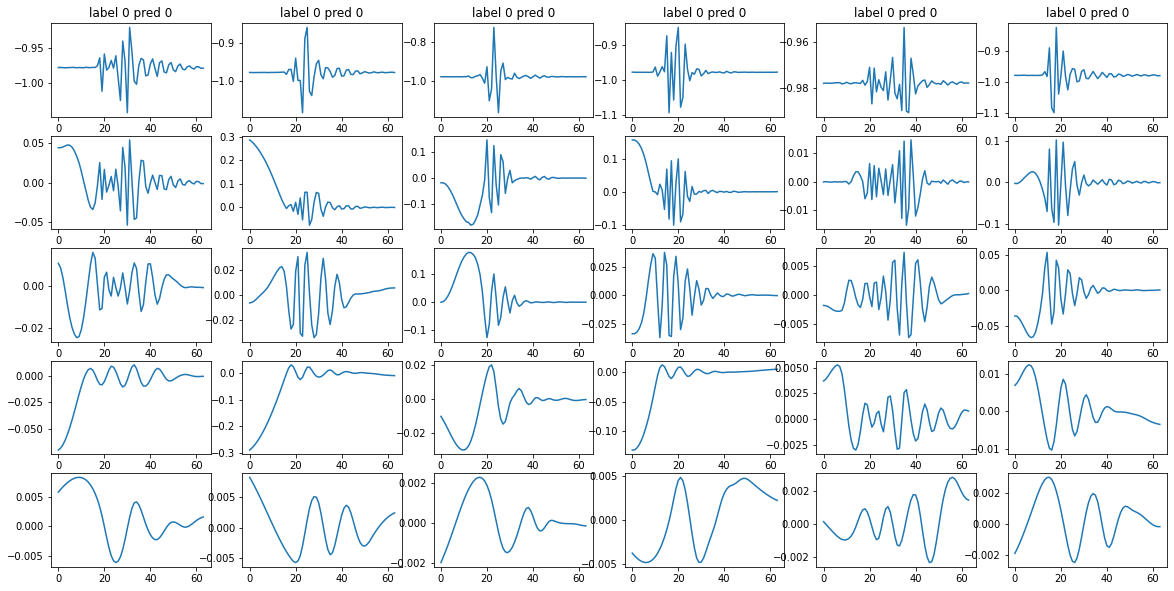

In [20]:
plot_hht(item_list)

In [71]:
# zwy三个场地上都为dig, 且误识
# idx = np.random.choice(zwy_wrong_idx, size=, replace=False)
idx = zwy_wrong_idx
item1 = {'data': zwy_samples[idx[0]]['data_z'], 'label': zwy_samples[idx[0]]['label'], 'pred': zwy_preds[idx[0]]}
item2 = {'data': zwy_samples[idx[1]]['data_z'], 'label': zwy_samples[idx[1]]['label'], 'pred': zwy_preds[idx[1]]}
item3 = {'data': zwy_samples[idx[2]]['data_z'], 'label': zwy_samples[idx[2]]['label'], 'pred': zwy_preds[idx[2]]}
item4 = {'data': zwy_samples[idx[3]]['data_z'], 'label': zwy_samples[idx[3]]['label'], 'pred': zwy_preds[idx[3]]}
# item5 = {'data': zwy_samples[idx[4]]['data_z'], 'label': zwy_samples[idx[4]]['label'], 'pred': zwy_preds[idx[4]]}
# item6 = {'data': zwy_samples[idx[5]]['data_z'], 'label': zwy_samples[idx[5]]['label'], 'pred': zwy_preds[idx[5]]}
item_list = [item1, item2, item3, item4]

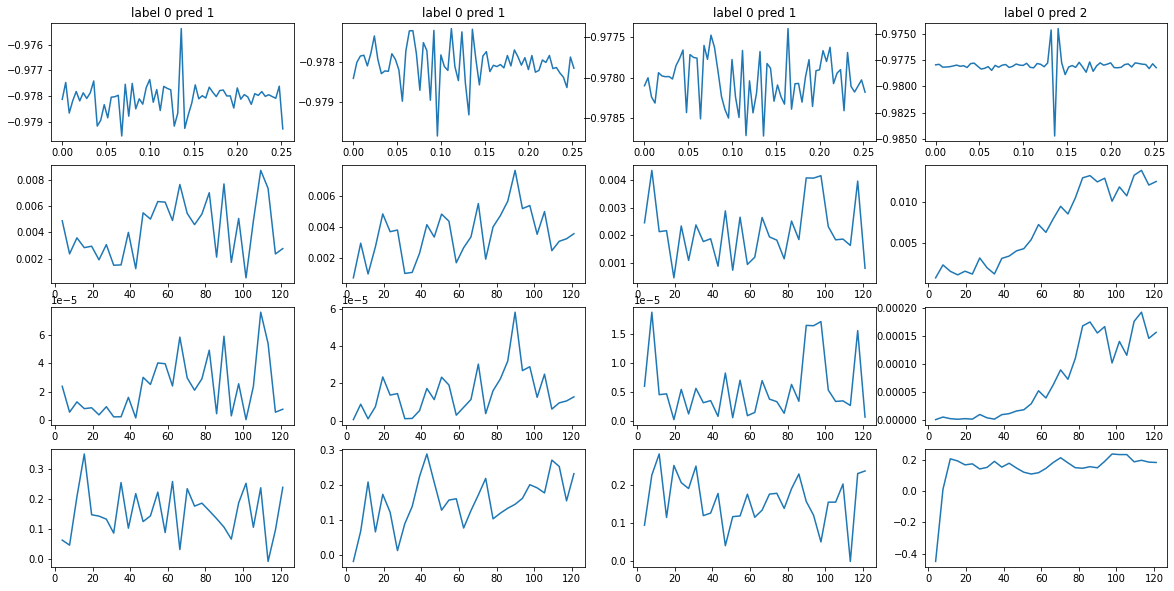

In [72]:
plot_fft(item_list)

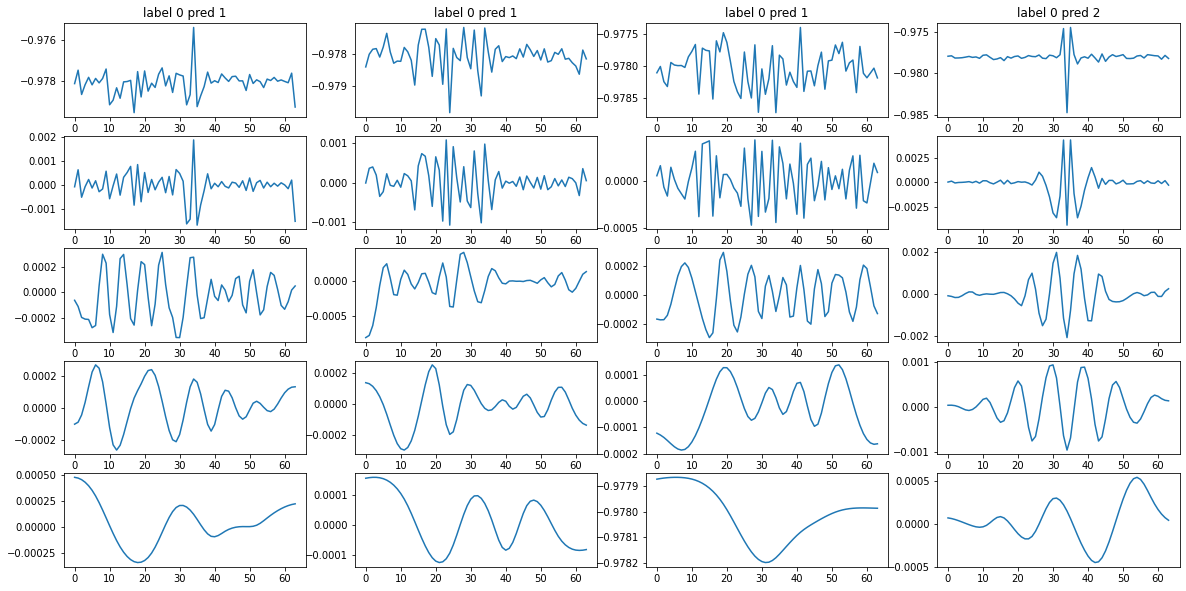

In [73]:
plot_hht(item_list)

In [74]:
# sky2都为dig, 且误识
idx = np.random.choice(sky2_true_idx, size=6, replace=False)
# idx = sky2_true_idx
item1 = {'data': sky2_samples[idx[0]]['data_z'], 'label': sky2_samples[idx[0]]['label'], 'pred': sky2_preds[idx[0]]}
item2 = {'data': sky2_samples[idx[1]]['data_z'], 'label': sky2_samples[idx[1]]['label'], 'pred': sky2_preds[idx[1]]}
item3 = {'data': sky2_samples[idx[2]]['data_z'], 'label': sky2_samples[idx[2]]['label'], 'pred': sky2_preds[idx[2]]}
item4 = {'data': sky2_samples[idx[3]]['data_z'], 'label': sky2_samples[idx[3]]['label'], 'pred': sky2_preds[idx[3]]}
item5 = {'data': sky2_samples[idx[4]]['data_z'], 'label': sky2_samples[idx[4]]['label'], 'pred': sky2_preds[idx[4]]}
item6 = {'data': sky2_samples[idx[5]]['data_z'], 'label': sky2_samples[idx[5]]['label'], 'pred': sky2_preds[idx[5]]}
item_list = [item1, item2, item3, item4, item5, item6]

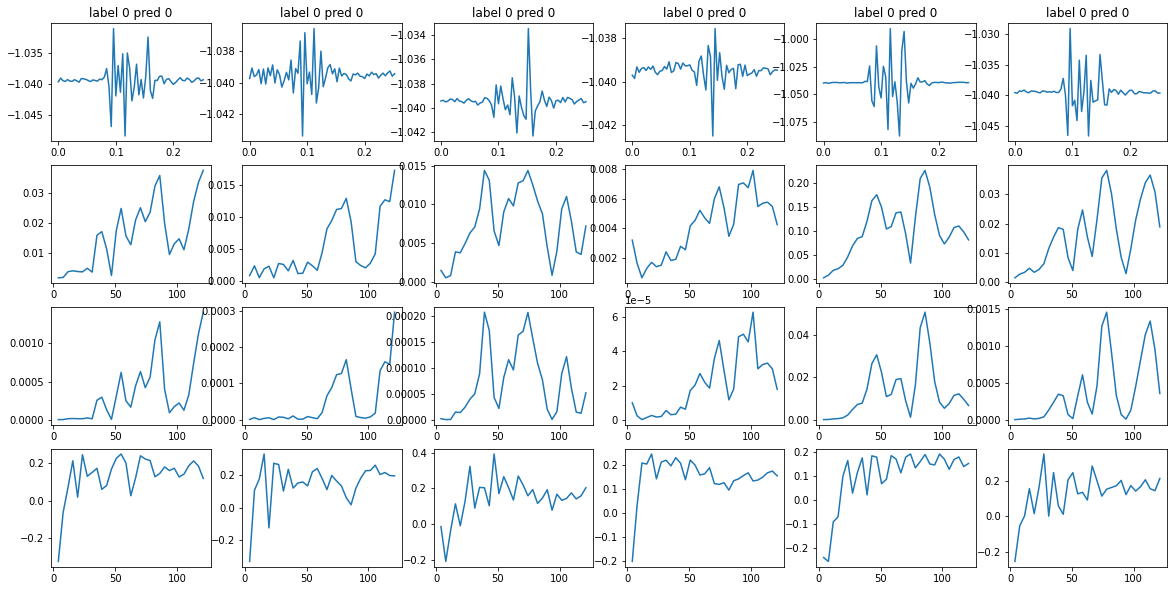

In [75]:
plot_fft(item_list)

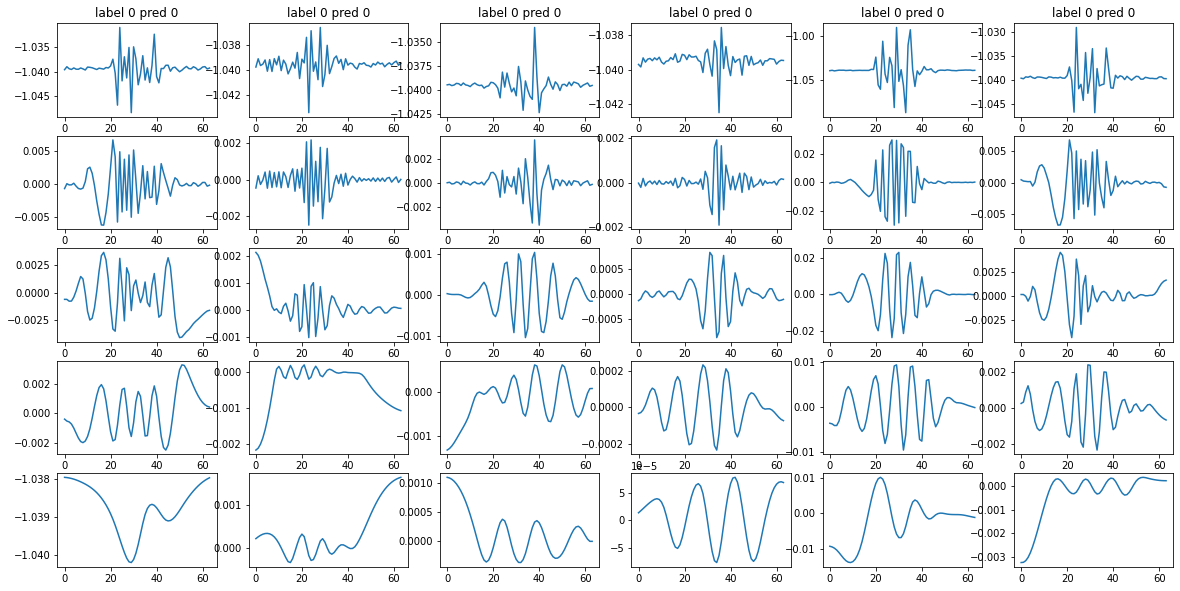

In [76]:
plot_hht(item_list)

In [77]:
# sky2都为dig, 且误识
idx = np.random.choice(sky2_wrong_idx, size=6, replace=False)
# idx = sky2_true_idx
item1 = {'data': sky2_samples[idx[0]]['data_z'], 'label': sky2_samples[idx[0]]['label'], 'pred': sky2_preds[idx[0]]}
item2 = {'data': sky2_samples[idx[1]]['data_z'], 'label': sky2_samples[idx[1]]['label'], 'pred': sky2_preds[idx[1]]}
item3 = {'data': sky2_samples[idx[2]]['data_z'], 'label': sky2_samples[idx[2]]['label'], 'pred': sky2_preds[idx[2]]}
item4 = {'data': sky2_samples[idx[3]]['data_z'], 'label': sky2_samples[idx[3]]['label'], 'pred': sky2_preds[idx[3]]}
item5 = {'data': sky2_samples[idx[4]]['data_z'], 'label': sky2_samples[idx[4]]['label'], 'pred': sky2_preds[idx[4]]}
item6 = {'data': sky2_samples[idx[5]]['data_z'], 'label': sky2_samples[idx[5]]['label'], 'pred': sky2_preds[idx[5]]}
item_list = [item1, item2, item3, item4, item5, item6]

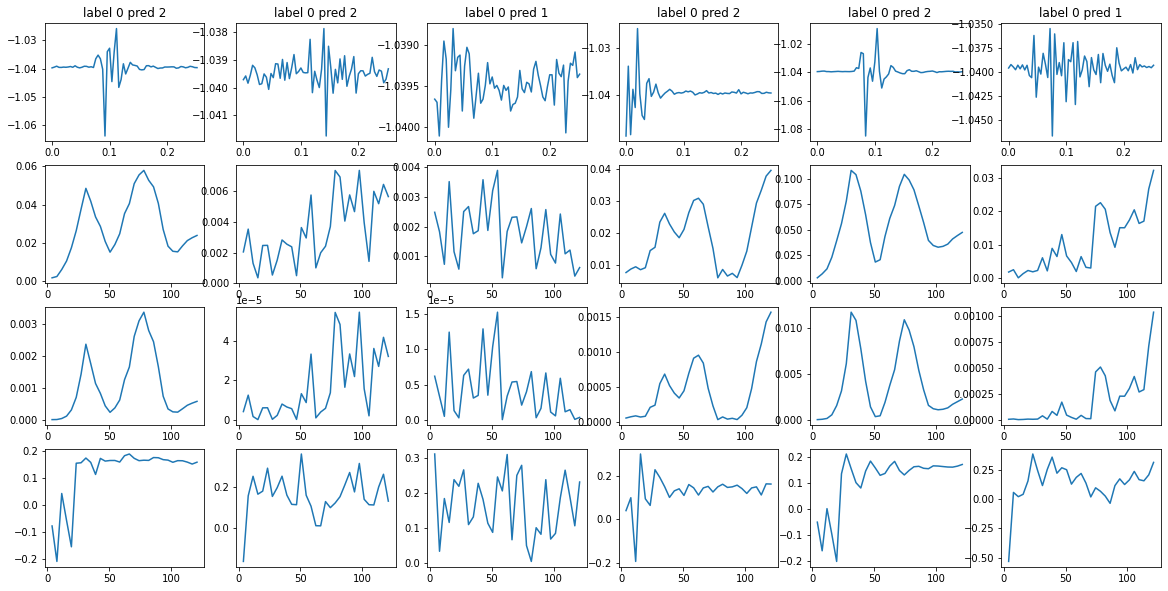

In [78]:
plot_fft(item_list)

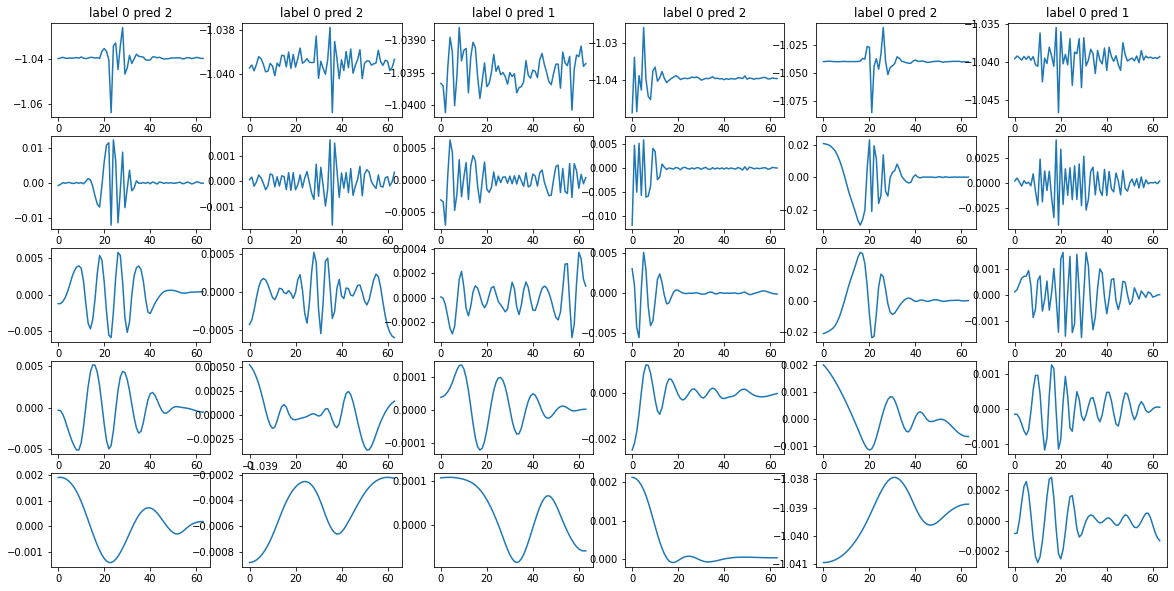

In [79]:
plot_hht(item_list)

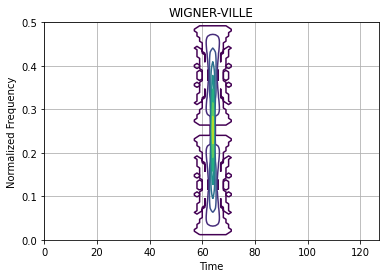

In [21]:
from tftb.generators import anapulse
from tftb.processing import WignerVilleDistribution

sig = anapulse(128)
wvd = WignerVilleDistribution(sig)
wvd.run()
wvd.plot(kind="contour", scale="log")


In [23]:
sig.shape

(128,)